In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

2024-06-04 16:37:25.269288: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 16:37:25.859356: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_styled_landmarks(image, results):
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [3]:
data_path = os.path.join('TrashData')
actions = np.array(['hello', 'thanks', 'eat', 'help'])
no_sequences = 30
sequence_length = 30

for action in actions:
    for sequence in range(1, no_sequences + 1):
        try:
            os.makedirs(os.path.join(data_path, action, str(sequence)))
        except FileExistsError:
            pass

In [4]:
ls /dev/video*

/dev/video0  /dev/video1


In [5]:
#2? sheesh! index 1 doesn't work

In [6]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(1, no_sequences + 1):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_styled_landmarks(image, results)

                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else:
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)

                keypoints = extract_keypoints(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

cap.release()
cv2.destroyAllWindows()


I0000 00:00:1717499252.860692   31129 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1717499252.866377   52676 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.1.0-arch1.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1717499252.953451   52667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717499252.964962   52667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717499252.968855   52666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717499252.968855   52667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature i

In [8]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

no_sequences = 30
sequence_length = 30

data_path = 'TrashData'
actions = np.array(['hello', 'thanks', 'eat', 'help'])

label_map = {label: num for num, label in enumerate(actions)}
sequences, labels = [], []

for action in actions:
    for sequence in range(1, no_sequences + 1):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

sequences = np.array(sequences)
labels = np.array(labels)

print(f"Shape of sequences: {sequences.shape}")
print(f"Shape of labels: {labels.shape}")

sequence_length = sequences.shape[1]  # bruhh ~30
keypoints_size = sequences.shape[2]   # 1662

# (samples, sequence_length, keypoints_size, 1)
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=len(actions))
y_test = to_categorical(y_test, num_classes=len(actions))

X_train = X_train.reshape(-1, sequence_length, keypoints_size, 1)
X_test = X_test.reshape(-1, sequence_length, keypoints_size, 1)

print("Shape of:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


Shape of sequences: (120, 30, 1662)
Shape of labels: (120,)
Shape of:
X_train: (96, 30, 1662, 1)
X_test: (24, 30, 1662, 1)
y_train: (96, 4)
y_test: (24, 4)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Conv1D, MaxPooling1D

sequence_length = 30
keypoints_size = 1662  # size(keypoints) after flattening

model = Sequential([
    InputLayer(input_shape=(sequence_length, keypoints_size, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


/home/VintellX/.local/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2024-06-04 16:43:48.858566: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 16:43:48.858929: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 1662, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 831, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 831, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 415, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 415, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 207, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 79488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,087,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,180,228 (19.76 MB)

 Trainable params: 5,180,228 (19.76 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
print(f"Sequences shape: {sequences.shape}")

print(f"Total elements: {sequences.size}")

Sequences shape: (120, 30, 1662)
Total elements: 5983200


In [11]:
sequences = sequences.reshape(sequences.shape[0], sequences.shape[1], sequences.shape[2], 1)

print(f"Sequences after reshaping: {sequences.shape}")


Sequences after reshaping: (120, 30, 1662, 1)


In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

sequences = sequences.reshape((sequences.shape[0], 30, 1662, 1))

labels = to_categorical(labels, num_classes=len(actions))

X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
print("Shapes of:")
print()
print(f"X_train:\t{X_train.shape}")
print(f"X_test:\t\t{X_test.shape}")
print(f"y_train:\t{y_train.shape}")
print(f"y_test:\t\t{y_test.shape}")


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))


Shapes of:

X_train:	(96, 30, 1662, 1)
X_test:		(24, 30, 1662, 1)
y_train:	(96, 4)
y_test:	(24, 4)
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 809ms/step - accuracy: 0.2630 - loss: 2.9518 - val_accuracy: 0.2917 - val_loss: 1.3656
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 753ms/step - accuracy: 0.2708 - loss: 1.3776 - val_accuracy: 0.4167 - val_loss: 1.3928
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 740ms/step - accuracy: 0.2370 - loss: 1.3997 - val_accuracy: 0.7083 - val_loss: 1.3771
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 753ms/step - accuracy: 0.3737 - loss: 1.3799 - val_accuracy: 0.6667 - val_loss: 1.3663
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 753ms/step - accuracy: 0.3424 - loss: 1.3646 - val_accuracy: 0.4167 - val_loss: 1.3562
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 751ms/step - accuracy: 0.3685 - loss: 1.3479 - val_accuracy: 0.4167 - val_loss: 1.3353
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 758ms/step - accuracy: 0.3268 - loss: 1.3434 - val_accuracy: 0.6667 - val_loss: 1.2999
Epoch 8/100


In [13]:
print(keypoints.size)


1662


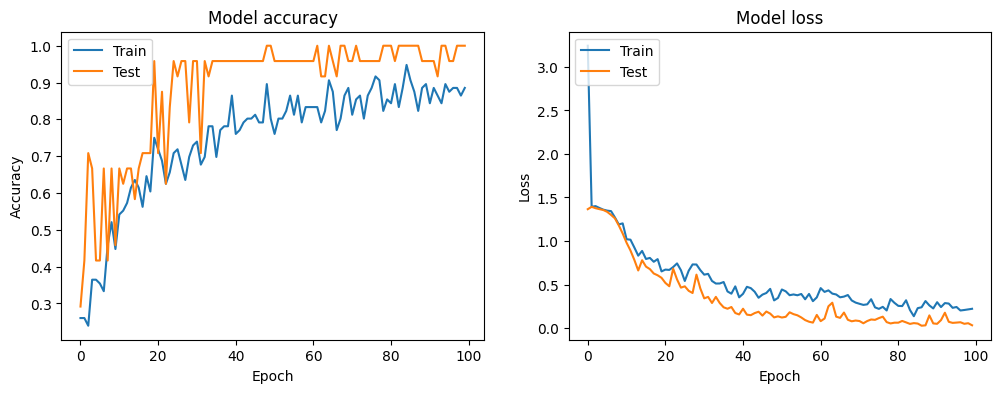

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [15]:
predictions = model.predict(X_test)
predicted = np.argmax(predictions, axis=1)
forReal = np.argmax(y_test, axis=1)

print(f"Predicted:\t{predicted}")
print(f"For Real:\t{forReal}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Predicted:	[1 1 0 1 0 2 2 0 1 3 0 2 0 1 2 3 3 0 2 3 2 1 1 2]
For Real:	[1 1 0 1 0 2 2 0 1 3 0 2 0 1 2 3 3 0 2 3 2 1 1 2]


In [16]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)

        keypoints = extract_keypoints(results)
        if keypoints.size == 1662:
            keypoints = np.expand_dims(keypoints, axis=0)
            keypoints = np.repeat(keypoints, 30, axis=0)
            keypoints = keypoints.reshape(1, 30, 1662, 1)
        else:
            raise ValueError(f"Fuck it! Expected 1662 keypoints, but got {keypoints.size}")
        
        print(f"keypoints sahpe: {keypoints.shape}")
        
        predictions = model.predict(keypoints)
        predicted_class = actions[np.argmax(predictions)]
        
        cv2.putText(image, f'Prediction: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1717500008.279289   31129 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1717500008.279786   56100 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.1.0-arch1.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1717500008.333352   56094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717500008.344506   56090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717500008.345261   56095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717500008.345261   56092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 

keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/home/VintellX/.local/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17